In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import scipy.ndimage as ndimage
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
import torch
import torch.backends.cudnn as cudnn
import argparse



2022-04-28 20:27:00.508598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/felipe/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-04-28 20:27:00.508624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


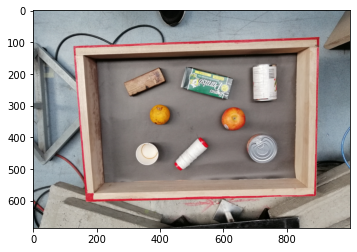

In [2]:
rgb_img = cv2.imread('bin.png', cv2.IMREAD_UNCHANGED)
rgb_img= cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)


In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


In [14]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2
pipeline_config = 'models/retina_config/config/pipeline.config'
checkpoint_path = "models/retina_config/checkpoint/ckpt-1"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
     _prediction_heads=detection_model._box_predictor._prediction_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [15]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [16]:
resized = cv2.resize(rgb_img, (640,480), interpolation = cv2.INTER_AREA)

In [18]:
label_id_offset = 1
path="/content/resized.jpg"
#input_tensor = tf.convert_to_tensor(np.expand_dims(load_image_into_numpy_array(path), axis=0), dtype=tf.float32)
input_tensor = tf.convert_to_tensor(np.expand_dims(resized, axis=0), dtype=tf.float32)
detections = detect(input_tensor)

In [19]:
detections['detection_boxes'][0][0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.07383603, 0.0635595 , 0.89384335, 0.9056431 ], dtype=float32)>

In [20]:
shape=resized.shape
bin_img=resized[int(shape[0]*detections['detection_boxes'][0][0][0]):int(shape[0]*detections['detection_boxes'][0][0][2]),int(shape[1]*detections['detection_boxes'][0][0][1]):int(shape[1]*detections['detection_boxes'][0][0][3])]

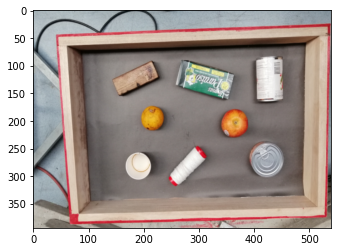

In [21]:
plt.imshow(bin_img)